# Mississippi River Plume Total Suspended Solids (TSS) Analysis

This notebook analyzes satellite data to calculate Total Suspended Solids (TSS) in the Mississippi River plume across different time periods.

In [ ]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# Attempt to reload the module to pick up recent changes
import importlib
import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

In [2]:
def atmospheric_correction(Rrs_645_meas, aot_869, lambda_meas=645, lambda_aot=869, alpha=1.3):
    """
    Corrects the measured water-leaving reflectance at a given wavelength 
    for atmospheric aerosol effects.

    Parameters:
      Rrs_645_meas : float or np.array
          Measured remote sensing reflectance at 645 nm.
      aot_869 : float or np.array
          Aerosol Optical Thickness at 869 nm.
      lambda_meas : int, optional
          The wavelength (nm) of the reflectance measurement (default is 645 nm).
      lambda_aot : int, optional
          The wavelength (nm) at which AOT is provided (default is 869 nm).
      alpha : float, optional
          Aerosol spectral exponent (default is 1.3).

    Returns:
      Rrs_645_corr : float or np.array
          Atmospherically corrected Rrs at 645 nm.
    """
    # Compute the aerosol optical thickness at lambda_meas (645 nm) using spectral scaling.
    tau_lambda = aot_869 * (lambda_meas / lambda_aot) ** (-alpha)
    # Apply the correction: assuming an exponential attenuation effect.
    Rrs_645_corr = Rrs_645_meas * np.exp(-tau_lambda)
    return Rrs_645_corr

def calculate_tss(Rrs_645_meas, aot_869):
    """
    Estimates Total Suspended Solids (TSS) in mg L^-1 using
    an atmospheric correction based on AOT_869 and the Nechad et al. (2010) model.

    Parameters:
      Rrs_645_meas : float or np.array
          Measured remote sensing reflectance at 645 nm.
      aot_869 : float or np.array
          Aerosol Optical Thickness at 869 nm.

    Returns:
      tss : float or np.array
          Estimated TSS (mg L^-1). Returns np.nan when the corrected reflectance 
          is not within the model's valid range.
    """
    # Step 1: Apply the atmospheric correction to Rrs at 645 nm.
    Rrs_645_corr = atmospheric_correction(Rrs_645_meas, aot_869)
    
    # Step 2: Use the Nechad et al. (2010) model to compute TSS.
    # Literature-based calibration coefficients for turbid waters:
    A = 289      # Empirical coefficient (mg L^-1)
    B = 0.168    # Saturation reflectance level

    # Calculate TSS using the semi-analytical model.
    # This formulation is valid as long as Rrs_645_corr < B to avoid unphysical results.
    with np.errstate(divide='ignore', invalid='ignore'):
        tss = A * Rrs_645_corr / (1 - Rrs_645_corr / B)
        
    # Enforce physical constraints: if Rrs exceeds B (or is nan), TSS is set to nan.
    tss = np.where((np.isnan(Rrs_645_corr)) | (Rrs_645_corr >= B), np.nan, tss)
    
    return tss

# Fallback TSS calculation when only one variable is available
def calculate_tss_fallback(reflectance):
    """Simple TSS calculation when only reflectance data is available"""
    a = 289.29
    b = 0.1686
    tss = a * reflectance / (1 - reflectance / b)
    return np.where(np.isnan(reflectance) | (reflectance >= b), np.nan, tss)

In [3]:
! dir "E:\satdata"

 Volume in drive E is Data
 Volume Serial Number is 18AA-E419

 Directory of E:\satdata

04/15/2025  09:19 AM    <DIR>          .
04/15/2025  09:18 AM    <DIR>          Atchafalaya_2021-06-21_2021-07-21
04/15/2025  09:19 AM    <DIR>          Atchafalaya_2022-03-18_2022-04-16
04/15/2025  09:19 AM    <DIR>          Atchafalaya_2022-06-19_2022-07-19
04/15/2025  09:08 AM    <DIR>          Mississippi_2021-06-21_2021-07-21
04/15/2025  09:19 AM    <DIR>          Mississippi_2022-03-18_2022-04-16
04/15/2025  09:19 AM    <DIR>          Mississippi_2022-06-19_2022-07-19
               0 File(s)              0 bytes
               7 Dir(s)  1,728,219,213,824 bytes free


In [4]:
# Specify the data directory and search recursively for netCDF files
data_dir = r"E:\satdata\Mississippi_2021-06-21_2021-07-21"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)

In [5]:
geo = xr.open_dataset(nc_files[0], group="geophysical_data")

print("\n> GEOPHYSICAL VARIABLES:")

for var in geo.variables:
    print(f"{var}: {geo[var].dims} – {geo[var].shape}")

# Check if required variables are available in the dataset
available_vars = list(geo.variables)
print("\n> CHECKING REQUIRED VARIABLES:")
aot_var = 'aot_869'
rrs_var = 'rrs_645'
print(f"AOT variable '{aot_var}' available: {aot_var in available_vars}")
print(f"RRS variable '{rrs_var}' available: {rrs_var in available_vars}")

# If rrs_645 is not available, check if Rrs_645 (uppercase) is available
if rrs_var not in available_vars and 'Rrs_645' in available_vars:
    rrs_var = 'Rrs_645'
    print(f"Using alternative RRS variable: {rrs_var}")


> GEOPHYSICAL VARIABLES:
aot_869: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
angstrom: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_412: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_443: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_469: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_488: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_531: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_547: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_555: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_645: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_667: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Rrs_678: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
chlor_a: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
Kd_490: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
pic: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
poc: ('number_of_lines', 'pixels_

In [ ]:
# Try to load both required variables, with error handling
aot_var = 'aot_869'
rrs_var = 'rrs_645'  # or 'Rrs_645' if lowercase not available

# Track which variables are successfully loaded
variables_loaded = {}

# Load AOT data
try:
    aot_loader = L2DatasetLoader(variables=[aot_var])  # Changed: variable to variables
    aot_datasets = aot_loader.load_multiple(nc_files)
    print(f"Loaded {len(aot_datasets)} datasets for {aot_var}.")
    variables_loaded['aot'] = len(aot_datasets) > 0
except Exception as e:
    print(f"Error loading {aot_var}: {str(e)}")
    aot_datasets = []
    variables_loaded['aot'] = False

# Try lowercase rrs_645 first
try:
    rrs_loader = L2DatasetLoader(variables=[rrs_var])  # Changed: variable to variables
    rrs_datasets = rrs_loader.load_multiple(nc_files)
    print(f"Loaded {len(rrs_datasets)} datasets for {rrs_var}.")
    variables_loaded['rrs'] = len(rrs_datasets) > 0
except Exception as e:
    print(f"Error loading {rrs_var}: {str(e)}")

    # Try uppercase Rrs_645 as fallback
    try:
        alt_rrs_var = 'Rrs_645'
        print(f"Trying alternative variable: {alt_rrs_var}")
        rrs_loader = L2DatasetLoader(variables=[alt_rrs_var])  # Changed: variable to variables
        rrs_datasets = rrs_loader.load_multiple(nc_files)
        print(f"Loaded {len(rrs_datasets)} datasets for {alt_rrs_var}.")
        rrs_var = alt_rrs_var  # Update the variable name
        variables_loaded['rrs'] = len(rrs_datasets) > 0
    except Exception as e2:
        print(f"Error loading alternative {alt_rrs_var}: {str(e2)}")
        rrs_datasets = []
        variables_loaded['rrs'] = False

# Report on status of data loading
print("\nData Loading Summary:")
print(f"AOT data available: {variables_loaded.get('aot', False)}")
print(f"RRS data available: {variables_loaded.get('rrs', False)}")

# Determine which TSS calculation method to use
if variables_loaded.get('aot', False) and variables_loaded.get('rrs', False):
    print("\nWill use atmospheric correction TSS calculation with both variables.")
    use_dual_var_tss = True
elif variables_loaded.get('rrs', False):
    print("\nWill use fallback TSS calculation with only RRS data.")
    use_dual_var_tss = False
elif variables_loaded.get('aot', False):
    print("\nWill use AOT data as reflectance proxy for TSS calculation.")
    use_dual_var_tss = False
    # Use AOT as a proxy for reflectance if that's all we have
    rrs_datasets = aot_datasets
    rrs_var = aot_var
else:
    print("\nERROR: No usable data available for TSS calculation.")

Loaded 41 datasets for aot_869.
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210621T183501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210622T191501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210623T182000.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210623T200000.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210624T190501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210625T194501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210626T185000.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210627T193501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2021-06-21_2021-07-21\AQ

In [7]:
# Check data availability with error handling
if variables_loaded.get('aot', False):
    print(f'Confirming {aot_var} data availability:')
    for i, ds in enumerate(aot_datasets):
        if aot_var in ds:
            band = ds[aot_var]
            print(f"Dataset {i}: min={band.min().values}, max={band.max().values}, mean={band.mean().values}")
        else:
            print(f"Dataset {i} does not contain {aot_var}")

if variables_loaded.get('rrs', False):
    print(f'\nConfirming {rrs_var} data availability:')
    for i, ds in enumerate(rrs_datasets):
        if rrs_var in ds:
            band = ds[rrs_var]
            print(f"Dataset {i}: min={band.min().values}, max={band.max().values}, mean={band.mean().values}")
        else:
            print(f"Dataset {i} does not contain {rrs_var}")

Confirming aot_869 data availability:
Dataset 0: min=0.014499999582767487, max=0.5304999947547913, mean=0.1390635222196579
Dataset 1: min=0.016999999061226845, max=0.49959999322891235, mean=0.16238990426063538
Dataset 2: min=0.0, max=0.48429998755455017, mean=0.13713841140270233
Dataset 3: min=0.01640000008046627, max=0.2945999801158905, mean=0.14394713938236237
Dataset 4: min=0.0, max=0.5113999843597412, mean=0.17401716113090515
Dataset 5: min=0.0, max=0.4129999876022339, mean=0.12187332659959793
Dataset 6: min=0.0, max=0.5181999802589417, mean=0.14010708034038544
Dataset 7: min=0.0, max=0.47689998149871826, mean=0.12109078466892242
Dataset 8: min=0.0, max=0.5289999842643738, mean=0.1135760173201561
Dataset 9: min=0.0, max=0.5199999809265137, mean=0.14020580053329468
Dataset 10: min=0.0, max=0.4509999752044678, mean=0.10660845041275024
Dataset 11: min=0.0, max=0.5148999691009521, mean=0.14293207228183746
Dataset 12: min=0.0, max=0.42819997668266296, mean=0.08867079019546509
Dataset 13

In [ ]:
# Data extraction with error handling
try:
    # Extract data for the variables we have
    if variables_loaded.get('aot', False):
        aot_extractor = GPUDataExtractor(variables=[aot_var])  # Changed: pass list
        aot_data_extracted = aot_extractor.extract(aot_datasets)
        if aot_data_extracted and len(aot_data_extracted) == 3:
            aot_lon, aot_lat, aot_var_data = aot_data_extracted
            print(f"Extracted {len(aot_var_data)} AOT data points")
        else:
            print("Warning: AOT data extraction returned empty or invalid result")
            variables_loaded['aot'] = False
    
    if variables_loaded.get('rrs', False):
        rrs_extractor = GPUDataExtractor(variables=[rrs_var])  # Changed: pass list
        rrs_data_extracted = rrs_extractor.extract(rrs_datasets)
        if rrs_data_extracted and len(rrs_data_extracted) == 3:
            rrs_lon, rrs_lat, rrs_var_data = rrs_data_extracted
            print(f"Extracted {len(rrs_var_data)} RRS data points")
        else:
            print("Warning: RRS data extraction returned empty or invalid result")
            variables_loaded['rrs'] = False
    
    # Update the dual variable flag based on available extracted data
    use_dual_var_tss = variables_loaded.get('aot', False) and variables_loaded.get('rrs', False)
    
except Exception as e:
    print(f"Error during data extraction: {str(e)}")
    # If extraction fails, we'll need to fall back to simpler methods

Extracted 12033069 AOT data points


In [9]:
from scipy.stats import binned_statistic_2d

# Define Bounding Box
lon_min, lon_max = -91.5, -87.5
lat_min, lat_max = 28.0, 30.0

try:
    # Process data based on which variables are available
    if use_dual_var_tss:
        # We have both variables, process AOT data
        aot_mask = ((aot_lon >= lon_min) & (aot_lon <= lon_max) & 
                   (aot_lat >= lat_min) & (aot_lat <= lat_max))
        aot_clipped_lon = aot_lon[aot_mask]
        aot_clipped_lat = aot_lat[aot_mask]
        aot_clipped_var = aot_var_data[aot_mask]
        
        # Process RRS data
        rrs_mask = ((rrs_lon >= lon_min) & (rrs_lon <= lon_max) & 
                   (rrs_lat >= lat_min) & (rrs_lat <= lat_max))
        rrs_clipped_lon = rrs_lon[rrs_mask]
        rrs_clipped_lat = rrs_lat[rrs_mask]
        rrs_clipped_var = rrs_var_data[rrs_mask]
        
        # Define binning parameters
        lat_bins, lon_bins = 200, 300
        
        # Bin AOT data
        aot_stat, lat_edges, lon_edges, _ = binned_statistic_2d(
            aot_clipped_lat, aot_clipped_lon, aot_clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        # Bin RRS data
        rrs_stat, _, _, _ = binned_statistic_2d(
            rrs_clipped_lat, rrs_clipped_lon, rrs_clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
    else:
        # We only have one variable (either AOT or RRS), use whichever is available
        if variables_loaded.get('rrs', False):
            # Use RRS data only
            data_lon, data_lat, data_var = rrs_lon, rrs_lat, rrs_var_data
            var_name = rrs_var
        else:
            # Use AOT data only
            data_lon, data_lat, data_var = aot_lon, aot_lat, aot_var_data
            var_name = aot_var
        
        # Process the available data
        data_mask = ((data_lon >= lon_min) & (data_lon <= lon_max) & 
                    (data_lat >= lat_min) & (data_lat <= lat_max))
        data_clipped_lon = data_lon[data_mask]
        data_clipped_lat = data_lat[data_mask]
        data_clipped_var = data_var[data_mask]
        
        # Define binning parameters
        lat_bins, lon_bins = 200, 300
        
        # Bin the data
        data_stat, lat_edges, lon_edges, _ = binned_statistic_2d(
            data_clipped_lat, data_clipped_lon, data_clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        print(f"Processed {var_name} data for single-variable TSS calculation")
    
    # Generate meshgrid for pcolormesh using bin edges
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    
except Exception as e:
    print(f"Error during data processing: {str(e)}")

Processed aot_869 data for single-variable TSS calculation


In [10]:
threshold = 32

try:
    if use_dual_var_tss:
        # Interpolate both variables
        aot_binned = SelectiveInterpolator.interpolate(aot_stat, lat_edges, lon_edges, threshold)
        rrs_binned = SelectiveInterpolator.interpolate(rrs_stat, lat_edges, lon_edges, threshold)
        
        # Calculate TSS using both variables
        tss_binned = calculate_tss(rrs_binned, aot_binned)
        print("Calculated TSS using both RRS and AOT variables")
    else:
        # Interpolate the single available variable
        data_binned = SelectiveInterpolator.interpolate(data_stat, lat_edges, lon_edges, threshold)
        
        # Calculate TSS using fallback method
        tss_binned = calculate_tss_fallback(data_binned)
        print(f"Calculated TSS using fallback method with {var_name} data")
        
except Exception as e:
    print(f"Error during TSS calculation: {str(e)}")
    print("Creating placeholder data for visualization")
    # Create placeholder data in case of error
    tss_binned = np.full((lat_bins, lon_bins), np.nan)

Calculated TSS using fallback method with aot_869 data


In [ ]:
# Process Mississippi_2022-06-19_2022-07-19 TSS data with error handling
import glob, os
from scipy.stats import binned_statistic_2d

try:
    data_dir2 = r"E:\satdata\Mississippi_2022-06-19_2022-07-19"
    nc_files2 = glob.glob(os.path.join(data_dir2, '**', '*.nc'), recursive=True)
    
    # Reset variables tracking for second period
    variables_loaded2 = {}
    
    # Load both variables for second time period
    try:
        aot_datasets2 = aot_loader.load_multiple(nc_files2)
        variables_loaded2['aot'] = len(aot_datasets2) > 0
        print(f"Loaded {len(aot_datasets2)} AOT datasets for 2022-06-19 to 2022-07-19.")
    except Exception as e:
        print(f"Error loading AOT data for period 2: {str(e)}")
        aot_datasets2 = []
        variables_loaded2['aot'] = False
    
    try:
        rrs_datasets2 = rrs_loader.load_multiple(nc_files2)
        variables_loaded2['rrs'] = len(rrs_datasets2) > 0
        print(f"Loaded {len(rrs_datasets2)} RRS datasets for 2022-06-19 to 2022-07-19.")
    except Exception as e:
        print(f"Error loading RRS data for period 2: {str(e)}")
        rrs_datasets2 = []
        variables_loaded2['rrs'] = False
    
    # Determine calculation method for period 2
    use_dual_var_tss2 = variables_loaded2.get('aot', False) and variables_loaded2.get('rrs', False)
    
    # Extract and process data based on availability
    if use_dual_var_tss2:
        # Extract data for both variables
        aot_lon2, aot_lat2, aot_var2 = GPUDataExtractor(variables=[aot_var]).extract(aot_datasets2)  # Changed
        rrs_lon2, rrs_lat2, rrs_var2 = GPUDataExtractor(variables=[rrs_var]).extract(rrs_datasets2)  # Changed
        
        # Process AOT data
        aot_mask2 = ((aot_lon2 >= lon_min) & (aot_lon2 <= lon_max) & 
                    (aot_lat2 >= lat_min) & (aot_lat2 <= lat_max))
        aot_clipped_lon2 = aot_lon2[aot_mask2]
        aot_clipped_lat2 = aot_lat2[aot_mask2]
        aot_clipped_var2 = aot_var2[aot_mask2]
        
        # Process RRS data
        rrs_mask2 = ((rrs_lon2 >= lon_min) & (rrs_lon2 <= lon_max) & 
                    (rrs_lat2 >= lat_min) & (rrs_lat2 <= lat_max))
        rrs_clipped_lon2 = rrs_lon2[rrs_mask2]
        rrs_clipped_lat2 = rrs_lat2[rrs_mask2]
        rrs_clipped_var2 = rrs_var2[rrs_mask2]
        
        # Bin data
        aot_stat2, lat_edges2, lon_edges2, _ = binned_statistic_2d(
            aot_clipped_lat2, aot_clipped_lon2, aot_clipped_var2,
            statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        rrs_stat2, _, _, _ = binned_statistic_2d(
            rrs_clipped_lat2, rrs_clipped_lon2, rrs_clipped_var2,
            statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        # Interpolate and calculate TSS
        aot_binned2 = SelectiveInterpolator.interpolate(aot_stat2, lat_edges2, lon_edges2, threshold)
        rrs_binned2 = SelectiveInterpolator.interpolate(rrs_stat2, lat_edges2, lon_edges2, threshold)
        
        # Compute TSS using both variables
        tss_binned2 = calculate_tss(rrs_binned2, aot_binned2)
    else:
        # Single variable calculation
        if variables_loaded2.get('rrs', False):
            var_name2 = rrs_var
            data_extractor = GPUDataExtractor(variables=[var_name2])  # Changed
            data_lon2, data_lat2, data_var2 = data_extractor.extract(rrs_datasets2)
        elif variables_loaded2.get('aot', False):
            var_name2 = aot_var
            data_extractor = GPUDataExtractor(variables=[var_name2])  # Changed
            data_lon2, data_lat2, data_var2 = data_extractor.extract(aot_datasets2)
        else:
            print("No data available for period 2")
            # Create placeholder data
            tss_binned2 = np.full((lat_bins, lon_bins), np.nan)
            lon_grid2, lat_grid2 = lon_grid, lat_grid
            lat_edges2, lon_edges2 = lat_edges, lon_edges
            raise ValueError("No data available for period 2")
        
        # Process the available data
        data_mask2 = ((data_lon2 >= lon_min) & (data_lon2 <= lon_max) & 
                     (data_lat2 >= lat_min) & (data_lat2 <= lat_max))
        data_clipped_lon2 = data_lon2[data_mask2]
        data_clipped_lat2 = data_lat2[data_mask2]
        data_clipped_var2 = data_var2[data_mask2]
        
        # Bin data
        data_stat2, lat_edges2, lon_edges2, _ = binned_statistic_2d(
            data_clipped_lat2, data_clipped_lon2, data_clipped_var2,
            statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        # Interpolate and calculate TSS
        data_binned2 = SelectiveInterpolator.interpolate(data_stat2, lat_edges2, lon_edges2, threshold)
        tss_binned2 = calculate_tss_fallback(data_binned2)
    
    lon_grid2, lat_grid2 = np.meshgrid(lon_edges2, lat_edges2)
    print('Processed TSS for 2022-06-19 to 2022-07-19')
    
except Exception as e:
    print(f"Error processing period 2 data: {str(e)}")
    print("Creating placeholder data for period 2")
    tss_binned2 = np.full((lat_bins, lon_bins), np.nan)
    lon_grid2, lat_grid2 = lon_grid, lat_grid
    lat_edges2, lon_edges2 = lat_edges, lon_edges

Loaded 46 AOT datasets for 2022-06-19 to 2022-07-19.
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220619T194001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220620T184501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220621T192500.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220621T193001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220622T183001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220622T183501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220622T201001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-06-19_2022-07-19\AQUA_MODIS.20220623T191500.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_202

In [ ]:
# Process Mississippi_2022-03-18_2022-04-16 TSS data with error handling
import glob, os
from scipy.stats import binned_statistic_2d

try:
    data_dir3 = r"E:\satdata\Mississippi_2022-03-18_2022-04-16"
    nc_files3 = glob.glob(os.path.join(data_dir3, '**', '*.nc'), recursive=True)
    
    # Reset variables tracking for third period
    variables_loaded3 = {}
    
    # Load both variables for third time period
    try:
        aot_datasets3 = aot_loader.load_multiple(nc_files3)
        variables_loaded3['aot'] = len(aot_datasets3) > 0
        print(f"Loaded {len(aot_datasets3)} AOT datasets for 2022-03-18 to 2022-04-16.")
    except Exception as e:
        print(f"Error loading AOT data for period 3: {str(e)}")
        aot_datasets3 = []
        variables_loaded3['aot'] = False
    
    try:
        rrs_datasets3 = rrs_loader.load_multiple(nc_files3)
        variables_loaded3['rrs'] = len(rrs_datasets3) > 0
        print(f"Loaded {len(rrs_datasets3)} RRS datasets for 2022-03-18 to 2022-04-16.")
    except Exception as e:
        print(f"Error loading RRS data for period 3: {str(e)}")
        rrs_datasets3 = []
        variables_loaded3['rrs'] = False
    
    # Determine calculation method for period 3
    use_dual_var_tss3 = variables_loaded3.get('aot', False) and variables_loaded3.get('rrs', False)
    
    # Extract and process data based on availability
    if use_dual_var_tss3:
        # Extract data for both variables
        aot_lon3, aot_lat3, aot_var3 = GPUDataExtractor(variables=[aot_var]).extract(aot_datasets3)  # Changed
        rrs_lon3, rrs_lat3, rrs_var3 = GPUDataExtractor(variables=[rrs_var]).extract(rrs_datasets3)  # Changed
        
        # Process AOT data
        aot_mask3 = ((aot_lon3 >= lon_min) & (aot_lon3 <= lon_max) & 
                    (aot_lat3 >= lat_min) & (aot_lat3 <= lat_max))
        aot_clipped_lon3 = aot_lon3[aot_mask3]
        aot_clipped_lat3 = aot_lat3[aot_mask3]
        aot_clipped_var3 = aot_var3[aot_mask3]
        
        # Process RRS data
        rrs_mask3 = ((rrs_lon3 >= lon_min) & (rrs_lon3 <= lon_max) & 
                    (rrs_lat3 >= lat_min) & (rrs_lat3 <= lat_max))
        rrs_clipped_lon3 = rrs_lon3[rrs_mask3]
        rrs_clipped_lat3 = rrs_lat3[rrs_mask3]
        rrs_clipped_var3 = rrs_var3[rrs_mask3]
        
        # Bin data
        aot_stat3, lat_edges3, lon_edges3, _ = binned_statistic_2d(
            aot_clipped_lat3, aot_clipped_lon3, aot_clipped_var3,
            statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        rrs_stat3, _, _, _ = binned_statistic_2d(
            rrs_clipped_lat3, rrs_clipped_lon3, rrs_clipped_var3,
            statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        # Interpolate and calculate TSS
        aot_binned3 = SelectiveInterpolator.interpolate(aot_stat3, lat_edges3, lon_edges3, threshold)
        rrs_binned3 = SelectiveInterpolator.interpolate(rrs_stat3, lat_edges3, lon_edges3, threshold)
        
        # Compute TSS using both variables
        tss_binned3 = calculate_tss(rrs_binned3, aot_binned3)
    else:
        # Single variable calculation
        if variables_loaded3.get('rrs', False):
            var_name3 = rrs_var
            data_extractor = GPUDataExtractor(variables=[var_name3])  # Changed
            data_lon3, data_lat3, data_var3 = data_extractor.extract(rrs_datasets3)
        elif variables_loaded3.get('aot', False):
            var_name3 = aot_var
            data_extractor = GPUDataExtractor(variables=[var_name3])  # Changed
            data_lon3, data_lat3, data_var3 = data_extractor.extract(aot_datasets3)
        else:
            print("No data available for period 3")
            # Create placeholder data
            tss_binned3 = np.full((lat_bins, lon_bins), np.nan)
            lon_grid3, lat_grid3 = lon_grid, lat_grid
            lat_edges3, lon_edges3 = lat_edges, lon_edges
            raise ValueError("No data available for period 3")
        
        # Process the available data
        data_mask3 = ((data_lon3 >= lon_min) & (data_lon3 <= lon_max) & 
                     (data_lat3 >= lat_min) & (data_lat3 <= lat_max))
        data_clipped_lon3 = data_lon3[data_mask3]
        data_clipped_lat3 = data_lat3[data_mask3]
        data_clipped_var3 = data_var3[data_mask3]
        
        # Bin data
        data_stat3, lat_edges3, lon_edges3, _ = binned_statistic_2d(
            data_clipped_lat3, data_clipped_lon3, data_clipped_var3,
            statistic='mean', bins=[lat_bins, lon_bins],
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        # Interpolate and calculate TSS
        data_binned3 = SelectiveInterpolator.interpolate(data_stat3, lat_edges3, lon_edges3, threshold)
        tss_binned3 = calculate_tss_fallback(data_binned3)
    
    lon_grid3, lat_grid3 = np.meshgrid(lon_edges3, lat_edges3)
    print('Processed TSS for 2022-03-18 to 2022-04-16')
    
except Exception as e:
    print(f"Error processing period 3 data: {str(e)}")
    print("Creating placeholder data for period 3")
    tss_binned3 = np.full((lat_bins, lon_bins), np.nan)
    lon_grid3, lat_grid3 = lon_grid, lat_grid
    lat_edges3, lon_edges3 = lat_edges, lon_edges

Loaded 17 AOT datasets for 2022-03-18 to 2022-04-16.
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220318T184500.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220319T192501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220319T193001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220320T183001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220320T183501.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220320T201001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220321T191500.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_2022-03-18_2022-04-16\AQUA_MODIS.20220322T182001.L2.OC.nc due to error: 'rrs_645'
Skipping E:\satdata\Mississippi_202

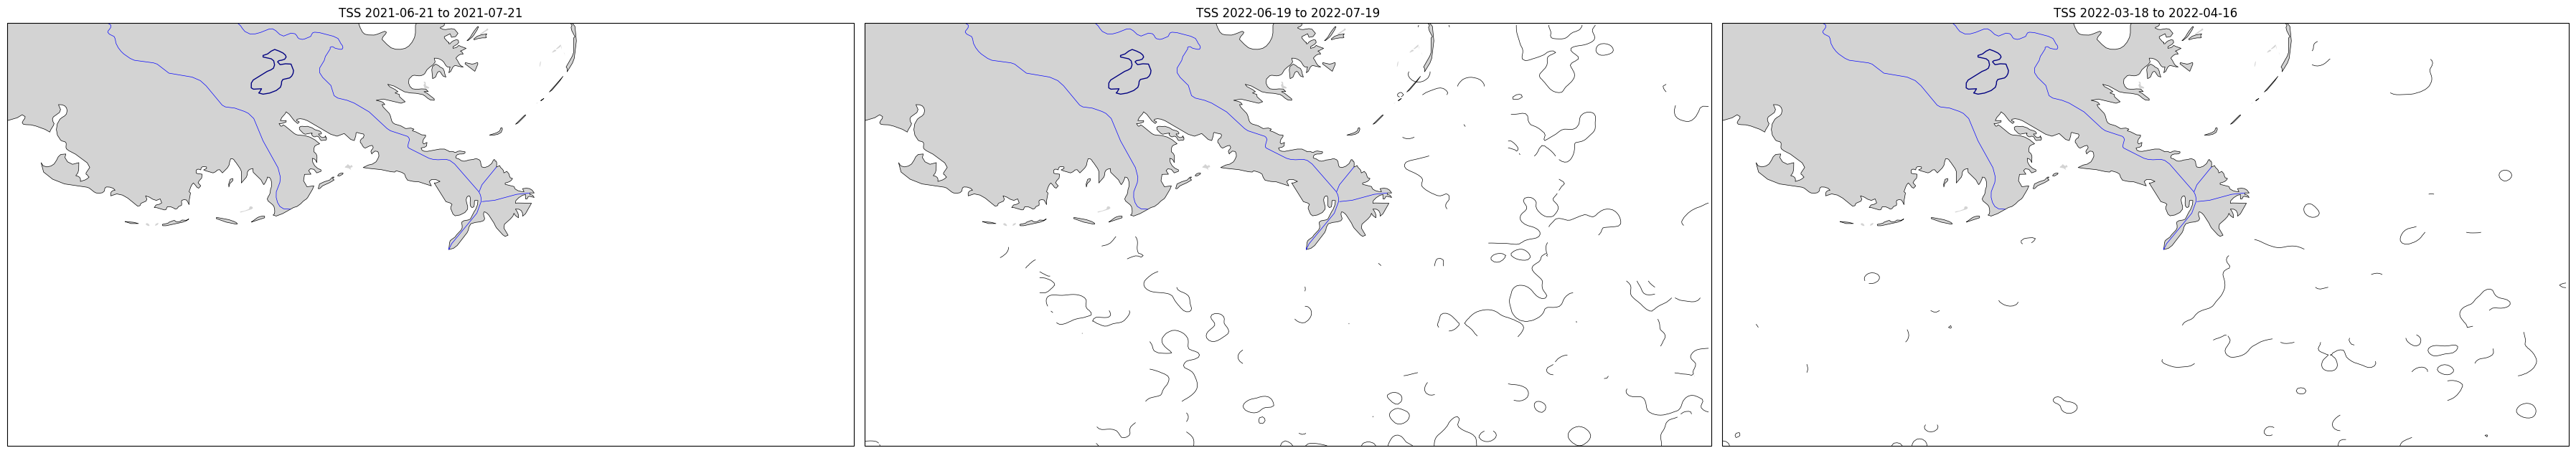

In [37]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian blur to the TSS data
sigma = 2  # Standard deviation for Gaussian kernel
tss_binned_blurred = gaussian_filter(tss_binned, sigma=sigma)
tss_binned2_blurred = gaussian_filter(tss_binned2, sigma=sigma)
tss_binned3_blurred = gaussian_filter(tss_binned3, sigma=sigma)

# Plot subplots for all three periods in one figure with 0-100 clipping as contour lines
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Color scale limits
graphmin = 0
graphmax = 10000000

# Define levels for posterized regions
levels = [100]

# Create the figure with error handling
try:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot for Mississippi_2021-06-21_2021-07-21
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax1.contour(lon_grid[:-1, :-1], lat_grid[:-1, :-1], tss_binned_blurred, levels=levels, 
                colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.LAND, facecolor='lightgray')
    ax1.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
    ax1.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')
    ax1.set_title('TSS 2021-06-21 to 2021-07-21')
    
    # Plot for Mississippi_2022-06-19_2022-07-19
    ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax2.contour(lon_grid2[:-1, :-1], lat_grid2[:-1, :-1], tss_binned2_blurred, levels=levels, 
                colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax2.add_feature(cfeature.LAND, facecolor='lightgray')
    ax2.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
    ax2.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')
    ax2.set_title('TSS 2022-06-19 to 2022-07-19')
    
    # Plot for Mississippi_2022-03-18_2022-04-16
    ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax3.contour(lon_grid3[:-1, :-1], lat_grid3[:-1, :-1], tss_binned3_blurred, levels=levels, 
                colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax3.add_feature(cfeature.LAND, facecolor='lightgray')
    ax3.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
    ax3.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')
    ax3.set_title('TSS 2022-03-18 to 2022-04-16')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {str(e)}")

In [20]:
print(np.nanmin(tss_binned), np.nanmax(tss_binned))
print(np.nanmin(tss_binned2), np.nanmax(tss_binned2))
print(np.nanmin(tss_binned3), np.nanmax(tss_binned3))


0.0 4026211585.8037114
0.0 1173170456.237397
2.239018459764415 328866.92010405415
